In [22]:
import sys
import os
import vamb
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

## Ground truth experiment

In [10]:
PATH_VAMB = '/Users/nmb127/Documents/vamb'
PATH_VAMB_DATA = '/Users/nmb127/Documents/vamb_data'

In [11]:
def parse_logfile(filepath):
    results = defaultdict(list)
    with open(f'{PATH_VAMB}/{filepath}') as f:
        for line in f:
            if line.startswith('loss_vamb'):
                for metric in line.split(', '):
                    k, v = metric.split(' ')
                    results[k].append(float(v))
    return results

In [33]:
def filterclusters(clusters, lengthof):
    filtered_bins = dict()
    for medoid, contigs in clusters.items():
        binsize = sum(lengthof[contig] for contig in contigs)
    
        if binsize >= 200000:
            filtered_bins[medoid] = contigs
    
    return filtered_bins

In [437]:
contig_path = f'{PATH_VAMB_DATA}/data/airways/contigs.fna'
with vamb.vambtools.Reader(contig_path, 'rb') as filehandle:
    tnfs, CONTIGNAMES, LENGTHS = vamb.parsecontigs.read_contigs(filehandle)
rpkms = vamb.vambtools.read_npz(f'{PATH_VAMB_DATA}/vamb_on_airways/depths.npz')
_, MASK = vamb.encode.make_dataloader(rpkms, tnfs)

In [436]:
def dataset_info(contig_path, depths_path, reference_path, taxonomy_path):
    with vamb.vambtools.Reader(contig_path, 'rb') as filehandle:
        tnfs, CONTIGNAMES, LENGTHS = vamb.parsecontigs.read_contigs(filehandle)
    rpkms = vamb.vambtools.read_npz(depths_path)
    _, MASK = vamb.encode.make_dataloader(rpkms, tnfs)
    with open(reference_path) as reference_file:
        REFERENCE = vamb.benchmark.Reference.from_file(reference_file)
    with open(taxonomy_path) as taxonomy_file:
        REFERENCE.load_tax_file(taxonomy_file)
    return CONTIGNAMES, MASK, LENGTHS, REFERENCE

In [451]:
reference_path

'/Users/nmb127/Documents/vamb_data/data/airways/reference.tsv'

In [17]:
reference_path = f'{PATH_VAMB_DATA}/data/airways/reference.tsv'

!head $reference_path # show first 10 lines of reference file

with open(reference_path) as reference_file:
    REFERENCE = vamb.benchmark.Reference.from_file(reference_file)

S23C236194	OTU_97.38699.0	CP013953.1	405835	408637
S23C27593	OTU_97.44406.0	CP015430.1	1591817	1594726
S23C53437	OTU_97.35057.0	CP012974.1	260542	266700
S23C191539	OTU_97.16597.0	CP010116.1	1675948	1678686
S23C111210	OTU_97.20680.0	CP013619.1	408162	411064
S23C216129	OTU_97.409.0	CP013957.1	103779	106015
S23C2782	OTU_97.45246.0	CP007573.1	1941619	1956892
S23C9729	OTU_97.44851.0	CP015426.1	1099587	1121671
S23C36165	OTU_97.409.0	CP013957.1	427732	429801
S23C90379	OTU_97.2104.0	CP019196.1	300725	303071


In [165]:
taxonomy_path = '/Users/nmb127/Documents/vamb_data/data/airways/taxonomy.tsv'

!head $taxonomy_path # show first 10 lines of reference file

with open(taxonomy_path) as taxonomy_file:
    reference.load_tax_file(taxonomy_file)

OTU_97.39766.0	Corynebacterium pseudotuberculosis	Corynebacterium
OTU_97.7195.0	Acinetobacter baumannii	Acinetobacter
OTU_97.34725.0	Staphylococcus aureus	Staphylococcus
OTU_97.1051.0	Corynebacterium ulcerans	Corynebacterium
OTU_97.34663.0	Staphylococcus aureus	Staphylococcus
OTU_97.8581.0	Corynebacterium doosanense	Corynebacterium
OTU_97.8702.0	Flavobacterium psychrophilum	Flavobacterium
OTU_97.31374.1	Corynebacterium ulcerans	Corynebacterium
OTU_97.479.0	Flavobacterium gilvum	Flavobacterium
OTU_97.37290.0	Staphylococcus equorum	Staphylococcus


In [448]:
def save_clusters(filepath, cluster_path, indices=None):
    print(filepath)
    latent_labels = np.load(f'{PATH_VAMB}/{filepath}')
    print(latent_labels.shape)
    if indices:
        print(len(indices))
        contignames, mask, lengths = \
            np.array(CONTIGNAMES)[indices], np.array(MASK)[indices], np.array(LENGTHS)[indices]
    else:
        contignames, mask, lengths = CONTIGNAMES, MASK, LENGTHS
    
    filtered_labels = [n for (n,m) in zip(contignames, mask) if m]
    cluster_iterator = vamb.cluster.cluster(latent_labels, labels=filtered_labels)
    clusters = dict(cluster_iterator)

    medoid, contigs = next(iter(clusters.items()))
    print('First key:', medoid, '(of type:', type(medoid), ')')
    print('Type of values:', type(contigs))
    print('First element of value:', next(iter(contigs)), 'of type:', type(next(iter(contigs))))

    lengthof = dict(zip(contignames, lengths))
    filtered_bins = filterclusters(vamb.vambtools.binsplit(clusters, 'C'), lengthof)
    print('Number of bins before splitting and filtering:', len(clusters))
    print('Number of bins after splitting and filtering:', len(filtered_bins))

    with open(f'{PATH_VAMB}/{cluster_path}', 'w') as file:
        vamb.vambtools.write_clusters(file, filtered_bins)


def bin_saved_clusters(cluster_path):
    with open(f'{PATH_VAMB}/{cluster_path}') as clusters_file:
        vamb_clusters = vamb.vambtools.read_clusters(clusters_file)
        vamb_clusters_clean = {k: [i.strip() for i in v] for k, v in vamb_clusters.items()}
        vamb_bins = vamb.benchmark.Binning(vamb_clusters_clean, REFERENCE, minsize=200000)
    return vamb_bins


In [362]:
lengthof = dict(zip(CONTIGNAMES, LENGTHS))

with open(f'{PATH_VAMB}/clusters.tsv') as clusters_file:
    vamb_clusters = vamb.vambtools.read_clusters(clusters_file)
    vamb_clusters_clean = {k: [i.strip() for i in v] for k, v in vamb_clusters.items()}
    filtered_bins = filterclusters(vamb.vambtools.binsplit(vamb_clusters_clean, 'C'), lengthof)
    vamb_bins = vamb.benchmark.Binning(filtered_bins, REFERENCE, minsize=200_000)

with open(f'{PATH_VAMB}/clusters.tsv') as clusters_file:
    vamb_clusters = vamb.benchmark.Binning.from_file(clusters_file, REFERENCE, minsize=200_000, binsplit_separator='C')

(vamb_clusters.counters[0][(0.9, 0.95)],
vamb_bins.counters[0][(0.9, 0.95)])

(78, 78)

In [374]:
lengthof = dict(zip(CONTIGNAMES, LENGTHS))

with open(f'{PATH_VAMB}/clusters_vamb_batchstep.tsv') as clusters_file:
    vamb_clusters = vamb.vambtools.read_clusters(clusters_file)
    vamb_clusters_clean = {k: [i.strip() for i in v] for k, v in vamb_clusters.items()}
    filtered_bins = filterclusters(vamb.vambtools.binsplit(vamb_clusters_clean, 'C'), lengthof)
    vamb_bins = vamb.benchmark.Binning(filtered_bins, REFERENCE, minsize=200_000)

with open(f'{PATH_VAMB}/clusters_vamb_batchstep.tsv') as clusters_file:
    vamb_clusters = vamb.benchmark.Binning.from_file(clusters_file, REFERENCE, minsize=200_000, binsplit_separator='C')

(vamb_clusters.counters[0][(0.9, 0.95)],
vamb_bins.counters[0][(0.9, 0.95)])


(56, 56)

In [395]:
save_clusters('latent_trained_vamb.npy', 'clusters_vamb_batchstep.tsv')

latent_trained_vamb.npy
(187685, 32)
First key: S4C262502 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S4C262502 of type: <class 'str'>
Number of bins before splitting and filtering: 69890
Number of bins after splitting and filtering: 481


In [449]:
save_clusters('latent.npz', 'clusters_vamb_results.tsv')

latent.npz
(81602, 32)


ValueError: Got 187685 labels for 81602 points

In [391]:
vamb_bins_batch = bin_saved_clusters('clusters_vamb_results.tsv')
vamb_bins_batch.counters[0][(0.9, 0.95)]

78

In [396]:
vamb_bins_batch = bin_saved_clusters('clusters_vamb_batchstep.tsv')
vamb_bins_batch.counters[0][(0.9, 0.95)]

79

In [435]:
save_clusters('latent_trained_vamb_gi.npy', 'clusters_gi.tsv')
vamb_gi = bin_saved_clusters('clusters_gi.tsv')
vamb_gi.counters[0][(0.9, 0.95)]

latent_trained_vamb_gi.npy
(81602, 32)


ValueError: Got 187685 labels for 81602 points

In [93]:
def save_clusters_both(filepath_vamb, filepath_both, indices_vamb, indices_both, cluster_path):
    latent_vamb = np.load(f'{PATH_VAMB}/{filepath_vamb}')
    latent_both = np.load(f'{PATH_VAMB}/{filepath_both}')
    new_indices = [np.argwhere(indices_vamb == i)[0][0] for i in indices_both]
    print(latent_both.shape, len(new_indices), indices_both.shape)
    latent_vamb[new_indices] = latent_both
    contignames, mask, lengths = \
        np.array(CONTIGNAMES)[indices_vamb], np.array(MASK)[indices_vamb], np.array(LENGTHS)[indices_vamb]
        
    filtered_labels = [n for (n,m) in zip(contignames, mask) if m]
    cluster_iterator = vamb.cluster.cluster(latent_vamb, labels=filtered_labels)
    clusters = dict(cluster_iterator)

    medoid, contigs = next(iter(clusters.items()))
    print('First key:', medoid, '(of type:', type(medoid), ')')
    print('Type of values:', type(contigs))
    print('First element of value:', next(iter(contigs)), 'of type:', type(next(iter(contigs))))

    lengthof = dict(zip(contignames, lengths))
    filtered_bins = filterclusters(vamb.vambtools.binsplit(clusters, 'C'), lengthof)
    print('Number of bins before splitting and filtering:', len(clusters))
    print('Number of bins after splitting and filtering:', len(filtered_bins))

    with open(f'{PATH_VAMB}/{cluster_path}', 'w') as file:
        vamb.vambtools.write_clusters(file, filtered_bins)

In [399]:
filepaths = [
    'latent_trained_semisupervised_1_both.npy',
    'latent_trained_semisupervised_1_vamb.npy',
    'latent_trained_semisupervised_1_labels.npy',
    
    'latent_trained_semisupervised_10_both.npy',
    'latent_trained_semisupervised_10_vamb.npy',
    'latent_trained_semisupervised_10_labels.npy',
    
    'latent_trained_semisupervised_50_both.npy',
    'latent_trained_semisupervised_50_vamb.npy',
    'latent_trained_semisupervised_50_labels.npy',
]
clusters = [
    'clusters_1_both.tsv',
    'clusters_1_vamb.tsv',
    'clusters_1_labels.tsv',
    
    'clusters_10_both.tsv',
    'clusters_10_vamb.tsv',
    'clusters_10_labels.tsv',
    
    'clusters_50_both.npy',
    'clusters_50_vamb.npy',
    'clusters_50_labels.npy',
]
filepaths_100 = [
    'latent_trained_semisupervised_100_both.npy',
    'latent_trained_semisupervised_100_vamb.npy',
    'latent_trained_semisupervised_100_labels.npy',
]
clusters_100 = [
    'clusters_100_both.tsv',
    'clusters_100_vamb.tsv',
    'clusters_100_labels.tsv',
]
filepaths_one = [
    'latent_trained_semisupervised.npy',
    'latent_trained_labels.npy',
    'latent_trained_vamb.npy',
]
clusters_one = [
    'clusters_concat.tsv',
    'clusters_labels.tsv',
    'clusters_vamb.tsv',
]
clusters_mixed = [
    'clusters_mixed1.tsv',
    'clusters_mixed10.tsv',
    'clusters_mixed50.tsv',
    'clusters_mixed100.tsv',
]
clusters_fix = [
    'clusters_mixed1_fix.tsv',
    'clusters_mixed10_fix.tsv',
    'clusters_mixed50_fix.tsv',
    'clusters_mixed100_fix.tsv',
]

In [411]:
filepaths_one_fix = [
    'latent_trained_semisupervised_fix_1_both.npy',
    'latent_trained_semisupervised_fix_1_vamb.npy',
    'latent_trained_semisupervised_fix_1_labels.npy',
    
    'latent_trained_semisupervised_fix_10_both.npy',
    'latent_trained_semisupervised_fix_10_vamb.npy',
    'latent_trained_semisupervised_fix_10_labels.npy',
    
    'latent_trained_semisupervised_fix_50_both.npy',
    'latent_trained_semisupervised_fix_50_vamb.npy',
    'latent_trained_semisupervised_fix_50_labels.npy',
    
    'latent_trained_semisupervised_fix_100_both.npy',
    'latent_trained_semisupervised_fix_100_vamb.npy',
    'latent_trained_semisupervised_fix_100_labels.npy',
]
clusters_one_fix = [
    'clusters_1_both_fix.tsv',
    'clusters_1_vamb_fix.tsv',
    'clusters_1_labels_fix.tsv',
    
    'clusters_10_both_fix.tsv',
    'clusters_10_vamb_fix.tsv',
    'clusters_10_labels_fix.tsv',
    
    'clusters_50_both_fix.npy',
    'clusters_50_vamb_fix.npy',
    'clusters_50_labels_fix.npy',
    
    'clusters_100_both_fix.tsv',
    'clusters_100_vamb_fix.tsv',
    'clusters_100_labels_fix.tsv',
]

In [412]:
filepaths_genus = [
    'latent_trained_semisupervised_genus_1_both.npy',
    'latent_trained_semisupervised_genus_1_vamb.npy',
    'latent_trained_semisupervised_genus_1_labels.npy',
    
    'latent_trained_semisupervised_genus_10_both.npy',
    'latent_trained_semisupervised_genus_10_vamb.npy',
    'latent_trained_semisupervised_genus_10_labels.npy',
    
    'latent_trained_semisupervised_genus_50_both.npy',
    'latent_trained_semisupervised_genus_50_vamb.npy',
    'latent_trained_semisupervised_genus_50_labels.npy',
    
    'latent_trained_semisupervised_genus_100_both.npy',
    'latent_trained_semisupervised_genus_100_vamb.npy',
    'latent_trained_semisupervised_genus_100_labels.npy',
]
clusters_genus = [
    'clusters_1_both_genus.tsv',
    'clusters_1_vamb_genus.tsv',
    'clusters_1_labels_genus.tsv',
    
    'clusters_10_both_genus.tsv',
    'clusters_10_vamb_genus.tsv',
    'clusters_10_labels_genus.tsv',
    
    'clusters_50_both_genus.npy',
    'clusters_50_vamb_genus.npy',
    'clusters_50_labels_genus.npy',
    
    'clusters_100_both_genus.tsv',
    'clusters_100_vamb_genus.tsv',
    'clusters_100_labels_genus.tsv',
]

In [417]:
with open(f'{PATH_VAMB}/indices_1.pickle', 'rb') as fp:
    indices1_x, indices1_y, indices1_sup = pickle.load(fp)
with open(f'{PATH_VAMB}/indices_10.pickle', 'rb') as fp:
    indices10_x, indices10_y, indices10_sup = pickle.load(fp)
with open(f'{PATH_VAMB}/indices_50.pickle', 'rb') as fp:
    indices50_x, indices50_y, indices50_sup = pickle.load(fp)
with open(f'{PATH_VAMB}/indices_100.pickle', 'rb') as fp:
    indices100_x, indices100_y, indices100_sup = pickle.load(fp)
    
with open(f'{PATH_VAMB}/indices_fix_1.pickle', 'rb') as fp:
    indices1_fix_x, indices1_fix_y, indices1_fix_sup = pickle.load(fp)
with open(f'{PATH_VAMB}/indices_fix_10.pickle', 'rb') as fp:
    indices10_fix_x, indices10_fix_y, indices10_fix_sup = pickle.load(fp)
with open(f'{PATH_VAMB}/indices_fix_50.pickle', 'rb') as fp:
    indices50_fix_x, indices50_fix_y, indices50_fix_sup = pickle.load(fp)
with open(f'{PATH_VAMB}/indices_fix_100.pickle', 'rb') as fp:
    indices100_fix_x, indices100_fix_y, indices100_fix_sup = pickle.load(fp)
    
with open(f'{PATH_VAMB}/indices_genus_1.pickle', 'rb') as fp:
    indices1_genus_x, indices1_genus_y, indices1_genus_sup = pickle.load(fp)
with open(f'{PATH_VAMB}/indices_genus_10.pickle', 'rb') as fp:
    indices10_genus_x, indices10_genus_y, indices10_genus_sup = pickle.load(fp)
with open(f'{PATH_VAMB}/indices_genus_50.pickle', 'rb') as fp:
    indices50_genus_x, indices50_genus_y, indices50_genus_sup = pickle.load(fp)
with open(f'{PATH_VAMB}/indices_genus_100.pickle', 'rb') as fp:
    indices100_genus_x, indices100_genus_y, indices100_genus_sup = pickle.load(fp)

In [397]:
with open(f'{PATH_VAMB}/indices_mmseq.pickle', 'rb') as fp:
    indices_mmseq = pickle.load(fp)

In [398]:
with open(f'{PATH_VAMB}/indices_mmseq_genus.pickle', 'rb') as fp:
    indices_mmseq_genus = pickle.load(fp)

In [51]:
indices = [
    indices1_sup, indices1_x, indices1_y,
    indices10_sup, indices10_x, indices10_y,
    indices50_sup, indices50_x, indices50_y,
]
indices_100 = [
    indices100_sup, indices100_x, indices100_y,
]

In [419]:
indices_fix = [
    indices1_fix_sup, indices1_fix_x, indices1_fix_y,
    indices10_fix_sup, indices10_fix_x, indices10_fix_y,
    indices50_fix_sup, indices50_fix_x, indices50_fix_y,
    indices100_fix_sup, indices100_fix_x, indices100_fix_y,
]

indices_genus = [
    indices1_genus_sup, indices1_genus_x, indices1_genus_y,
    indices10_genus_sup, indices10_genus_x, indices10_genus_y,
    indices50_genus_sup, indices50_genus_x, indices50_genus_y,
    indices100_genus_sup, indices100_genus_x, indices100_genus_y,
]

In [420]:
for p1, p2, ii in zip(filepaths_genus, clusters_genus, indices_genus):
    save_clusters(p1, p2, indices=ii)

latent_trained_semisupervised_genus_1_both.npy
(1877, 32)
1877
First key: S26C573052 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S26C573052 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 1665
Number of bins after splitting and filtering: 5
latent_trained_semisupervised_genus_1_vamb.npy
(187685, 32)
187685


KeyboardInterrupt: 

In [35]:
for p1, p2, ii in zip(filepaths, clusters, indices):
    save_clusters(p1, p2, indices=ii)

First key: S7C60636 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C94017 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 1
Number of bins after splitting and filtering: 10
First key: S27C166967 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C166967 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 36231
Number of bins after splitting and filtering: 427
First key: S27C8938 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C6358 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 639
Number of bins after splitting and filtering: 717
First key: S7C280317 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S7C280317 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 45
Number of bins after splitting and filtering: 10
First ke

In [58]:
for p1, p2, ii in zip(filepaths_100, clusters_100, indices_100):
    save_clusters(p1, p2, indices=ii)

latent_trained_semisupervised_100_both.npy
187685
First key: S27C141880 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C141880 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 12725
Number of bins after splitting and filtering: 20
latent_trained_semisupervised_100_vamb.npy
187685


KeyboardInterrupt: 

In [400]:
for p1, p2 in zip(filepaths_one, clusters_one):
    save_clusters(p1, p2)

latent_trained_semisupervised.npy
(187685, 32)
First key: S27C168155 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S27C39292 of type: <class 'str'>
Number of bins before splitting and filtering: 3653
Number of bins after splitting and filtering: 651
latent_trained_labels.npy
(187685, 32)
First key: S4C285569 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S27C39292 of type: <class 'str'>
Number of bins before splitting and filtering: 639
Number of bins after splitting and filtering: 717
latent_trained_vamb.npy
(187685, 32)
First key: S4C262502 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S4C262502 of type: <class 'str'>
Number of bins before splitting and filtering: 69890
Number of bins after splitting and filtering: 481


In [110]:
for p1, p2, ii in zip(filepaths_one_fix, clusters_one_fix, indices_fix):
    save_clusters(p1, p2, indices=ii)

latent_trained_semisupervised_fix_1_both.npy
1877
First key: S27C186599 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C186599 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 1450
Number of bins after splitting and filtering: 5
latent_trained_semisupervised_fix_1_vamb.npy
187685
First key: S11C12549 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S4C74390 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 14954
Number of bins after splitting and filtering: 460
latent_trained_semisupervised_fix_1_labels.npy
187685
First key: S27C106120 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C187220 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 639
Number of bins after splitting and filtering: 717
latent_trained_semisupervised_fix_10_both.npy
18769
First key: S27C66417 (of type: <class 'nu

In [421]:
save_clusters_both(
    'latent_trained_semisupervised_1_vamb.npy',
    'latent_trained_semisupervised_1_both.npy',
    np.array(indices1_x),
    np.array(indices1_sup),
    'clusters_mixed1.tsv',
)

(1877, 32) 1877 (1877,)


KeyboardInterrupt: 

In [ ]:
save_clusters_both(
    'latent_trained_semisupervised_10_vamb.npy',
    'latent_trained_semisupervised_10_both.npy',
    np.array(indices10_x),
    np.array(indices10_sup),
    'clusters_mixed10.tsv',
)

save_clusters_both(
    'latent_trained_semisupervised_50_vamb.npy',
    'latent_trained_semisupervised_50_both.npy',
    np.array(indices50_x),
    np.array(indices50_sup),
    'clusters_mixed50.tsv',
)

save_clusters_both(
    'latent_trained_semisupervised_100_vamb.npy',
    'latent_trained_semisupervised_100_both.npy',
    np.array(indices100_x),
    np.array(indices100_sup),
    'clusters_mixed100.tsv',
)

In [422]:
save_clusters_both(
    'latent_trained_semisupervised_genus_1_vamb.npy',
    'latent_trained_semisupervised_genus_1_both.npy',
    np.array(indices1_genus_x),
    np.array(indices1_genus_sup),
    'clusters_mixed1_genus.tsv',
)

save_clusters_both(
    'latent_trained_semisupervised_genus_10_vamb.npy',
    'latent_trained_semisupervised_genus_10_both.npy',
    np.array(indices10_genus_x),
    np.array(indices10_genus_sup),
    'clusters_mixed10_genus.tsv',
)

save_clusters_both(
    'latent_trained_semisupervised_genus_50_vamb.npy',
    'latent_trained_semisupervised_genus_50_both.npy',
    np.array(indices50_genus_x),
    np.array(indices50_genus_sup),
    'clusters_mixed50_genus.tsv',
)

save_clusters_both(
    'latent_trained_semisupervised_genus_100_vamb.npy',
    'latent_trained_semisupervised_genus_100_both.npy',
    np.array(indices100_genus_x),
    np.array(indices100_genus_sup),
    'clusters_mixed100_genus.tsv',
)

(1877, 32) 1877 (1877,)
First key: S27C43410 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C43410 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 40711
Number of bins after splitting and filtering: 440
(18769, 32) 18769 (18769,)
First key: S4C1430 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C25737 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 43264
Number of bins after splitting and filtering: 437
(93843, 32) 93843 (93843,)
First key: S12C221764 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S12C221764 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 57947
Number of bins after splitting and filtering: 508
(187685, 32) 187685 (187685,)
First key: S27C162006 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C162006 of type: <class 'nu

In [423]:
for n in [100, 50, 10, 1]:
    for s in ['species']:
        with open(f'{PATH_VAMB}/indices_species_{n}.pickle', 'rb') as fp:
            indices_species_x, indices_species_y, indices_species_sup = pickle.load(fp)
        save_clusters_both(
            f'latent_trained_semisupervised_species_{n}_vamb.npy',
            f'latent_trained_semisupervised_species_{n}_both.npy',
            np.array(indices_species_x),
            np.array(indices_species_sup),
            f'clusters_mixed{n}_species.tsv',
        )

(187685, 32) 187685 (187685,)
First key: S9C55256 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S7C95763 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 40257
Number of bins after splitting and filtering: 517
(93843, 32) 93843 (93843,)
First key: S7C151450 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S7C151450 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 49837
Number of bins after splitting and filtering: 579
(18769, 32) 18769 (18769,)
First key: S7C245673 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S7C245673 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 45566
Number of bins after splitting and filtering: 521
(1877, 32) 1877 (1877,)
First key: S9C411828 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S9C411828 of type: <class 'numpy.

In [256]:
clusters_mixed_genus = [
    'clusters_mixed1_genus.tsv',
    'clusters_mixed10_genus.tsv',
    'clusters_mixed50_genus.tsv',
    'clusters_mixed100_genus.tsv',
]

In [268]:
clusters_mixed_species = [
    'clusters_mixed1_species.tsv',
    'clusters_mixed10_species.tsv',
    'clusters_mixed50_species.tsv',
    'clusters_mixed100_species.tsv',
]

In [441]:
save_clusters_both(
    'latent_trained_semisupervised_mmseq_vamb.npy',
    'latent_trained_semisupervised_mmseq_both.npy',
    np.array(range(len(indices50_fix_x))),
    np.array(indices_mmseq),
    'clusters_mmseq.tsv',
)

(64054, 32) 64054 (64054,)
First key: S4C262502 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S4C262502 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 48404
Number of bins after splitting and filtering: 469


In [402]:
save_clusters_both(
    'latent_trained_semisupervised_mmseq_genus_vamb.npy',
    'latent_trained_semisupervised_mmseq_genus_both.npy',
    np.array(range(len(indices50_fix_x))),
    np.array(indices_mmseq_genus),
    'clusters_mmseq_genus.tsv',
)

(161719, 32) 161719 (161719,)
First key: S4C262502 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S4C262502 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 54635
Number of bins after splitting and filtering: 421


In [424]:
save_clusters_both(
    'latent_trained_semisupervised_fix_50_vamb.npy',
    'latent_trained_semisupervised_fix_50_both.npy',
    np.array(indices50_fix_x),
    np.array(indices50_fix_sup),
    'clusters_mixed50_fix.tsv',
)

(93843, 32) 93843 (93843,)
First key: S4C613994 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S4C613994 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 23544
Number of bins after splitting and filtering: 825


In [425]:
save_clusters_both(
    'latent_trained_semisupervised_fix_1_vamb.npy',
    'latent_trained_semisupervised_fix_1_both.npy',
    np.array(indices1_fix_x),
    np.array(indices1_fix_sup),
    'clusters_mixed1_fix.tsv',
)

save_clusters_both(
    'latent_trained_semisupervised_fix_10_vamb.npy',
    'latent_trained_semisupervised_fix_10_both.npy',
    np.array(indices10_fix_x),
    np.array(indices10_fix_sup),
    'clusters_mixed10_fix.tsv',
)

save_clusters_both(
    'latent_trained_semisupervised_fix_100_vamb.npy',
    'latent_trained_semisupervised_fix_100_both.npy',
    np.array(indices100_fix_x),
    np.array(indices100_fix_sup),
    'clusters_mixed100_fix.tsv',
)

(1877, 32) 1877 (1877,)
First key: S4C104419 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S7C136486 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 32756
Number of bins after splitting and filtering: 469
(18769, 32) 18769 (18769,)
First key: S11C7684 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S11C10674 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 30895
Number of bins after splitting and filtering: 573
(187685, 32) 187685 (187685,)
First key: S27C82303 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C251811 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 2570
Number of bins after splitting and filtering: 722


In [176]:
clusters_mmseq = [
    'clusters_mmseq.tsv',
]
clusters_mmseq_genus = [
    'clusters_mmseq_genus.tsv',
]

In [38]:
bins_all = [bin_saved_clusters(c) for c in clusters]

In [53]:
bins_100 = [bin_saved_clusters(c) for c in clusters_100]

In [61]:
bins_one = [bin_saved_clusters(c) for c in clusters_one]

In [97]:
bins_mixed = [bin_saved_clusters(c) for c in clusters_mixed]

In [428]:
bins_fix = [bin_saved_clusters(c) for c in clusters_fix]

In [111]:
bins_one_fix = [bin_saved_clusters(c) for c in clusters_one_fix]

In [426]:
bins_genus = [bin_saved_clusters(c) for c in clusters_mixed_genus]

In [427]:
bins_species = [bin_saved_clusters(c) for c in clusters_mixed_species]

In [262]:
bins_genus_one = [bin_saved_clusters(c) for c in clusters_genus]

In [345]:
bin_test = bin_saved_clusters('clusters.tsv')

In [259]:
all_clusters = clusters_one_fix + clusters_one + clusters_fix + clusters_mixed_genus
all_bins = bins_one_fix + bins_one + bins_fix + bins_genus

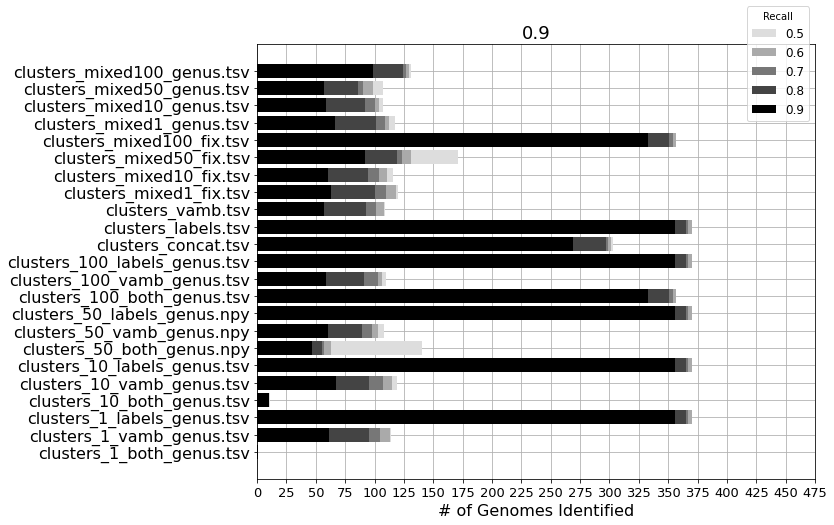

In [260]:
for precision in [0.9]:
    plt.figure(figsize=(10, 8))
    colors = ['#DDDDDD', '#AAAAAA', '#777777', '#444444', '#000000']
    recalls = [0.5, 0.6, 0.7, 0.8, 0.9]
    for y, bins in zip(range(len(all_clusters)), all_bins):
        for color, recall in zip(colors, recalls):
            plt.barh(y, bins.counters[0][(recall, precision)], color=color)

    plt.title(str(precision), fontsize=18)
    plt.yticks(list(range(len(all_clusters))), all_clusters, fontsize=16)
    plt.xticks([i*25 for i in range(20)], fontsize=13)
    plt.legend([str(i) for i in recalls], bbox_to_anchor=(1, 1.1), title='Recall', fontsize=12)
    
    if precision == 0.9:
        plt.xlabel('# of Genomes Identified', fontsize=16)
    plt.gca().set_axisbelow(True)
    plt.grid()

In [137]:
bins_concat, bins_labels, bins_vamb = bins_one
sup_levels = [1, 10, 50, 100]
bins_vamb_sup = [bins_one_fix[1], bins_one_fix[4], bins_one_fix[7], bins_one_fix[10]]
bins_labels_sup = [bins_one_fix[2], bins_one_fix[5], bins_one_fix[8], bins_one_fix[11]]

In [263]:
bins_vamb_genus = [bins_genus_one[1], bins_genus_one[4], bins_genus_one[7], bins_genus_one[10]]
bins_labels_genus = [bins_genus_one[2], bins_genus_one[5], bins_genus_one[8], bins_genus_one[11]]

In [238]:
bins_mmseq = [bin_saved_clusters(c) for c in clusters_mmseq]
bins_mmseq_genus = [bin_saved_clusters(c) for c in clusters_mmseq_genus]

In [322]:
bins_concat.counters[0][(rec, prec)], bins_labels.counters[0][(rec, prec)]

(269, 356)

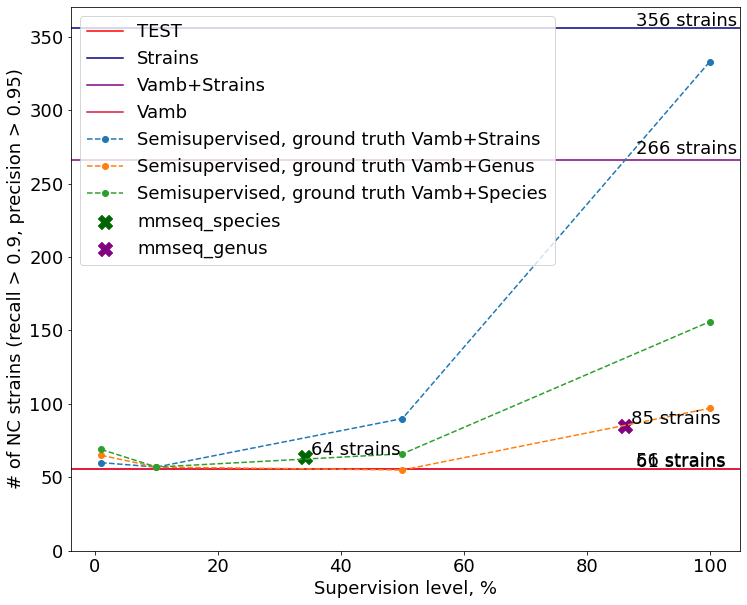

In [370]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(12, 10))
rec, prec = 0.9, 0.95

plt.axhline(y=vamb_bins_batch.counters[0][(rec, prec)], color='red', label='TEST')
plt.text(87 + 1, vamb_bins_batch.counters[0][(rec, prec)] + 1, f'{bin_test.counters[0][(rec, prec)]} strains')

plt.axhline(y=bins_labels.counters[0][(rec, prec)], color='navy', label='Strains')
plt.text(87 + 1, 356 + 1, f'{bins_labels.counters[0][(rec, prec)]} strains')
plt.axhline(y=bins_concat.counters[0][(rec, prec)], color='purple', label='Vamb+Strains')
plt.text(87 + 1, 269 + 1, f'{bins_concat.counters[0][(rec, prec)]} strains')
plt.axhline(y=bins_vamb.counters[0][(rec, prec)], color='crimson', label='Vamb')
plt.text(87 + 1, 57 + 1, f'{bins_vamb.counters[0][(rec, prec)]} strains')

plt.plot(sup_levels, [b.counters[0][(rec, prec)] for b in bins_fix], 'o--', label='Semisupervised, ground truth Vamb+Strains')
# plt.plot(sup_levels, [b.counters[0][(rec, prec)] for b in bins_vamb_sup], 'o--', label='Semisupervised, input Vamb')
# plt.plot(sup_levels, [b.counters[0][(rec, prec)] for b in bins_labels_sup], 'o--', label='Semisupervised, input Labels')

plt.plot(sup_levels, [b.counters[0][(rec, prec)] for b in bins_genus], 'o--', label='Semisupervised, ground truth Vamb+Genus')
plt.plot(sup_levels, [b.counters[0][(rec, prec)] for b in bins_species], 'o--', label='Semisupervised, ground truth Vamb+Species')

plt.scatter([64054.0*100 / 187685], [b.counters[0][(rec, prec)] for b in bins_mmseq], 
            s=[200], marker='X', label='mmseq_species', color='darkgreen')
a = bins_mmseq[0].counters[0][(rec, prec)]
plt.text(64054.0*100 / 187685 + 1, a + 1, f'{a} strains')

plt.scatter([161719.0*100 / 187685], [b.counters[0][(rec, prec)] for b in bins_mmseq_genus], 
            s=[200], marker='X', label='mmseq_genus', color='purple')
a = bins_mmseq_genus[0].counters[0][(rec, prec)]
plt.text(161719.0*100 / 187685 + 1, a + 1, f'{a} strains')




plt.ylim((0, 370))
# plt.xlim((0, 60))
plt.ylabel('# of NC strains (recall > 0.9, precision > 0.95)')
plt.xlabel('Supervision level, %')
plt.legend()
plt.savefig('/Users/nmb127/Downloads/mmseq_all.png')
plt.show()


In [191]:
bins_vamb.counters[0][(rec, prec)]

57

In [277]:
bins_mmseq_genus[0].counters[0][(rec, prec)]

89

In [339]:
64.0 / 56.0, 85.0 / 56, 64054.0*100 / 187685, 161719.0*100 / 187685

(1.1428571428571428, 1.5178571428571428, 34.128459919546046, 86.16511708447665)

## mmseq2 experiment

In [143]:
df_mmseq = pd.read_csv(f'{PATH_VAMB}/airways_taxonomy_clean_new.tsv', delimiter='\t', header=None)

In [145]:
df_mmseq[2].unique()

array(['genus', 'species', 'family', 'class', 'superkingdom', 'order',
       'phylum', 'no rank'], dtype=object)

In [147]:
df_mmseq_species = df_mmseq[df_mmseq[2] == 'species']

In [149]:
len(df_mmseq_species[3].unique())

727

In [159]:
contigs = np.array(CONTIGNAMES)
indices_mmseq = [np.argwhere(contigs == c)[0][0] for c in df_mmseq_species[0]]

In [163]:
df_mmseq_species[3]

2                      Staphylococcus aureus
3         Corynebacterium pseudotuberculosis
4                      Staphylococcus aureus
5                        Bacillus velezensis
6                      Staphylococcus aureus
                         ...                
187593                 Corynebacterium casei
187594    Corynebacterium pseudotuberculosis
187595            Corynebacterium glutamicum
187601                  Sphingomonas panacis
187603                 Staphylococcus aureus
Name: 3, Length: 64054, dtype: object

In [161]:
contigs[indices_mmseq]

array(['S7C321733', 'S7C322592', 'S7C323616', ..., 'S27C165633',
       'S11C16500', 'S11C16707'], dtype='<U10')

In [166]:
df_mmseq

,0,1,2,3,4,5,6,7,8
0,S7C319745,13420,genus,Pedobacter heparinus,12,11,5,0.61,d_Bacteria;p_Bacteroidota;c_Bacteroidia;o_Sphi...
1,S7C320794,35,genus,Acinetobacter baumannii,34,29,19,0.78,d_Bacteria;p_Proteobacteria;c_Gammaproteobacte...
2,S7C321733,14,species,Staphylococcus aureus,4,4,3,0.98,d_Bacteria;p_Firmicutes;c_Bacilli;o_Staphyloco...
3,S7C322592,271,species,Corynebacterium pseudotuberculosis,3,2,2,1.00,d_Bacteria;p_Actinobacteriota;c_Actinomycetia;...
4,S7C323616,14,species,Staphylococcus aureus,5,4,4,1.00,d_Bacteria;p_Firmicutes;c_Bacilli;o_Staphyloco...
...,...,...,...,...,...,...,...,...,...
187601,S11C16500,30360,species,Sphingomonas panacis,16,15,14,0.99,d_Bacteria;p_Proteobacteria;c_Alphaproteobacte...
187602,S11C16616,271,genus,Corynebacterium pseudotuberculosis,7,6,3,0.50,d_Bacteria;p_Actinobacteriota;c_Actinomycetia;...
187603,S11C16707,14,species,Staphylococcus aureus,12,12,12,1.00,d_Bacteria;p_Firmicutes;c_Bacilli;o_Staphyloco...
187604,S11C16787,13,genus,Staphylococcus,5,4,4,1.00,d_Bacteria;p_Firmicutes;c_Bacilli;o_Staphyloco...


In [193]:
df_mmseq_genus = df_mmseq[(df_mmseq[2] == 'genus') | (df_mmseq[2] == 'species')]

In [194]:
df_mmseq_genus

,0,1,2,3,4,5,6,7,8
0,S7C319745,13420,genus,Pedobacter heparinus,12,11,5,0.61,d_Bacteria;p_Bacteroidota;c_Bacteroidia;o_Sphi...
1,S7C320794,35,genus,Acinetobacter baumannii,34,29,19,0.78,d_Bacteria;p_Proteobacteria;c_Gammaproteobacte...
2,S7C321733,14,species,Staphylococcus aureus,4,4,3,0.98,d_Bacteria;p_Firmicutes;c_Bacilli;o_Staphyloco...
3,S7C322592,271,species,Corynebacterium pseudotuberculosis,3,2,2,1.00,d_Bacteria;p_Actinobacteriota;c_Actinomycetia;...
4,S7C323616,14,species,Staphylococcus aureus,5,4,4,1.00,d_Bacteria;p_Firmicutes;c_Bacilli;o_Staphyloco...
...,...,...,...,...,...,...,...,...,...
187601,S11C16500,30360,species,Sphingomonas panacis,16,15,14,0.99,d_Bacteria;p_Proteobacteria;c_Alphaproteobacte...
187602,S11C16616,271,genus,Corynebacterium pseudotuberculosis,7,6,3,0.50,d_Bacteria;p_Actinobacteriota;c_Actinomycetia;...
187603,S11C16707,14,species,Staphylococcus aureus,12,12,12,1.00,d_Bacteria;p_Firmicutes;c_Bacilli;o_Staphyloco...
187604,S11C16787,13,genus,Staphylococcus,5,4,4,1.00,d_Bacteria;p_Firmicutes;c_Bacilli;o_Staphyloco...


In [206]:
df_mmseq_genus['genus'] = df_mmseq_genus[8].str.split(';').str[5]

/var/folders/5b/1dk8bnws25l6w502hfdc8xw80000gn/T/ipykernel_12840/1367947976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mmseq_genus['genus'] = df_mmseq_genus[8].str.split(';').str[5]


In [208]:
len(df_mmseq_genus['genus'].unique())

500

In [213]:
df_tax = pd.read_csv(taxonomy_path, delimiter='\t', header=None)
df_ref = pd.read_csv(reference_path, delimiter='\t', header=None)

In [228]:
genus_dict = {r[0]: r[2] for _, r in df_tax.iterrows()}
species_dict = {r[0]: r[1] for _, r in df_tax.iterrows()}

In [229]:
df_ref['genus'] = df_ref[1].map(genus_dict)
df_ref['species'] = df_ref[1].map(species_dict)

In [230]:
len(genus_dict), len(species_dict)

(828, 828)

In [231]:
df_ref.species.value_counts(dropna=False)

Staphylococcus aureus                 41754
Corynebacterium pseudotuberculosis    13779
Escherichia coli                       6254
Corynebacterium glutamicum             5294
Neisseria meningitidis                 4922
                                      ...  
Streptococcus pantholopis                 1
Aerococcus urinaehominis                  1
Brevibacterium linens                     1
Corynebacterium doosanense                1
Paucibacter sp. KCTC 42545                1
Name: species, Length: 266, dtype: int64

In [232]:
df_ref

,0,1,2,3,4,genus,species
0,S23C236194,OTU_97.38699.0,CP013953.1,405835,408637,Staphylococcus,Staphylococcus aureus
1,S23C27593,OTU_97.44406.0,CP015430.1,1591817,1594726,Haemophilus,[Haemophilus] ducreyi
2,S23C53437,OTU_97.35057.0,CP012974.1,260542,266700,Staphylococcus,Staphylococcus aureus
3,S23C191539,OTU_97.16597.0,CP010116.1,1675948,1678686,Escherichia,Escherichia coli
4,S23C111210,OTU_97.20680.0,CP013619.1,408162,411064,Staphylococcus,Staphylococcus aureus
...,...,...,...,...,...,...,...
187680,S10C452544,OTU_97.11086.0,CP015831.1,849612,854660,Escherichia,Escherichia coli
187681,S10C406459,OTU_97.36530.0,CP012013.1,2217103,2221049,Staphylococcus,Staphylococcus aureus
187682,S10C287317,OTU_97.34832.0,CP001781.1,959338,962517,Staphylococcus,Staphylococcus aureus
187683,S10C136350,OTU_97.35501.0,CP014022.1,2434269,2437523,Staphylococcus,Staphylococcus lugdunensis


In [234]:
for n in [100, 50, 10, 1]:
    for s in ['species', 'genus']:
        print(f'qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N {s}_{n} -e Out/{s}_{n}.err -o Out/{s}_{n}.out -A cpr_10006 -W group_list=cpr_10006 computerome_semisupervised_{s}_{n}.sh')
                            
                            

qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N species_100 -e Out/species_100.err -o Out/species_100.out -A cpr_10006 -W group_list=cpr_10006 computerome_semisupervised_species_100.sh
qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N genus_100 -e Out/genus_100.err -o Out/genus_100.out -A cpr_10006 -W group_list=cpr_10006 computerome_semisupervised_genus_100.sh
qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N species_50 -e Out/species_50.err -o Out/species_50.out -A cpr_10006 -W group_list=cpr_10006 computerome_semisupervised_species_50.sh
qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N genus_50 -e Out/genus_50.err -o Out/genus_50.out -A cpr_10006 -W group_list=cpr_10006 computerome_semisupervised_genus_50.sh
qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N species_10 -e Out/species_10.err -o Out/species_10.out -A cpr_10006 -W group_list=cpr_10006 computero

In [410]:
for n in [100, 50, 10, 1]:
    for s in ['sup']:
        print(f'qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N {s}_{n} -e Out/{s}_{n}.err -o Out/{s}_{n}.out -A cpr_10006 -W group_list=cpr_10006 computerome_semisupervised_{n}.sh')
          

qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N sup_100 -e Out/sup_100.err -o Out/sup_100.out -A cpr_10006 -W group_list=cpr_10006 computerome_semisupervised_100.sh
qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N sup_50 -e Out/sup_50.err -o Out/sup_50.out -A cpr_10006 -W group_list=cpr_10006 computerome_semisupervised_50.sh
qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N sup_10 -e Out/sup_10.err -o Out/sup_10.out -A cpr_10006 -W group_list=cpr_10006 computerome_semisupervised_10.sh
qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N sup_1 -e Out/sup_1.err -o Out/sup_1.out -A cpr_10006 -W group_list=cpr_10006 computerome_semisupervised_1.sh


In [432]:
for s in ['oral', 'gi', 'skin', 'urog', 'metahit']:
    print(f'echo "./computerome_vamb.sh {s}" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N {s} -e Out/{s}.err -o Out/{s}.out -A cpr_10006 -W group_list=cpr_10006')



echo "./computerome_vamb.sh oral" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N oral -e Out/oral.err -o Out/oral.out -A cpr_10006 -W group_list=cpr_10006
echo "./computerome_vamb.sh gi" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N gi -e Out/gi.err -o Out/gi.out -A cpr_10006 -W group_list=cpr_10006
echo "./computerome_vamb.sh skin" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N skin -e Out/skin.err -o Out/skin.out -A cpr_10006 -W group_list=cpr_10006
echo "./computerome_vamb.sh urog" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N urog -e Out/urog.err -o Out/urog.out -A cpr_10006 -W group_list=cpr_10006
echo "./computerome_vamb.sh metahit" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N metahit -e Out/metahit.err -o Out/metahit.out -A cpr_10006 -W group_list=cpr_10006


In [465]:
for s in ['oral', 'gi', 'skin', 'urog', 'airways']:
    for m in ['mmseq_genus', 'mmseq']:
        print(f'echo "./computerome_semisupervised_{m}.sh {s}" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N {m}_{s} -e Out/{m}_{s}.err -o Out/{m}_{s}.out -A cpr_10006 -W group_list=cpr_10006')


echo "./computerome_semisupervised_mmseq_genus.sh oral" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N mmseq_genus_oral -e Out/mmseq_genus_oral.err -o Out/mmseq_genus_oral.out -A cpr_10006 -W group_list=cpr_10006
echo "./computerome_semisupervised_mmseq.sh oral" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N mmseq_oral -e Out/mmseq_oral.err -o Out/mmseq_oral.out -A cpr_10006 -W group_list=cpr_10006
echo "./computerome_semisupervised_mmseq_genus.sh gi" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N mmseq_genus_gi -e Out/mmseq_genus_gi.err -o Out/mmseq_genus_gi.out -A cpr_10006 -W group_list=cpr_10006
echo "./computerome_semisupervised_mmseq.sh gi" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N mmseq_gi -e Out/mmseq_gi.err -o Out/mmseq_gi.out -A cpr_10006 -W group_list=cpr_10006
echo "./computerome_semisupervised_mmseq_genus.sh skin" | qsub -d `pwd` -l nodes=1:ppn=4:gpu

In [481]:
MMSEQ_PATH = '/Users/nmb127/Documents/vamb_data/almeida_taxonomy.tsv'

df_mmseq = pd.read_csv(MMSEQ_PATH, delimiter='\t', header=None)
df_mmseq_genus = df_mmseq[(df_mmseq[2] == 'genus') | (df_mmseq[2] == 'species')]
df_mmseq_genus['genus'] = df_mmseq_genus[8].str.split(';').str[5]
contigs = np.array(contignames)
# indices_mmseq = [np.argwhere(contigs == c)[0][0] for c in df_mmseq_genus[0]]
# classes_order = list(df_mmseq_genus['genus'])

/var/folders/5b/1dk8bnws25l6w502hfdc8xw80000gn/T/ipykernel_12840/2847932704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mmseq_genus['genus'] = df_mmseq_genus[8].str.split(';').str[5]


In [485]:
df_mmseq_genus

,0,1,2,3,4,5,6,7,8,genus
1,SERR011100Ccontig33,309,genus,Prevotella,63,57,42,0.75,d_Bacteria;p_Bacteroidota;c_Bacteroidia;o_Bact...,g_Prevotella
2,SERR011100Ccontig65,309,genus,Prevotella,44,42,31,0.83,d_Bacteria;p_Bacteroidota;c_Bacteroidia;o_Bact...,g_Prevotella
4,SERR011100Ccontig129,65792,species,Methanobrevibacter A sp900766745,14,13,7,0.58,d_Archaea;p_Methanobacteriota;c_Methanobacteri...,g_Methanobrevibacter A
5,SERR011100Ccontig161,309,genus,Prevotella,15,11,9,0.98,d_Bacteria;p_Bacteroidota;c_Bacteroidia;o_Bact...,g_Prevotella
6,SERR011100Ccontig193,4064,genus,Butyrivibrio A,8,7,7,1.00,d_Bacteria;p_Firmicutes A;c_Clostridia;o_Lachn...,g_Butyrivibrio A
...,...,...,...,...,...,...,...,...,...,...
5892087,SERR1190946Ccontig16156,193,genus,Klebsiella A,4,4,2,0.50,d_Bacteria;p_Proteobacteria;c_Gammaproteobacte...,g_Klebsiella A
5892088,SERR1190946Ccontig16188,19061,species,Ruminococcus C sp000437255,6,5,3,0.60,d_Bacteria;p_Firmicutes A;c_Clostridia;o_Oscil...,g_Ruminococcus C
5892089,SERR1190946Ccontig16220,3755,genus,CAG-103,8,7,5,0.98,d_Bacteria;p_Firmicutes A;c_Clostridia;o_Oscil...,g_CAG-103
5892090,SERR1190946Ccontig16252,19952,species,CAG-345 sp000433315,4,4,4,1.00,d_Bacteria;p_Firmicutes;c_Bacilli;o_RFN20;f_CA...,g_CAG-345


In [484]:
def argwhere(c):
    return np.argwhere(contigs == c)[0][0]

vfunc = np.vectorize(argwhere)
indices_mmseq = vfunc(df_mmseq_genus[0])

['S4C8' 'S4C16' 'S4C19' ... 'S9C605209' 'S9C605237' 'S9C605274'] SERR011100Ccontig33


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# indices_mmseq = [np.argwhere(contigs == c)[0][0] for c in df_mmseq_genus[0]]
# classes_order = list(df_mmseq_genus['genus'])

In [473]:
for s in ['almeida']:
    print(f'qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=100gb,walltime=2:00:00:00 -r y -N mmseq_{s} -e Out/mmseq_{s}.err -o Out/mmseq_{s}.out -A cpr_10006 -W group_list=cpr_10006')


qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=100gb,walltime=2:00:00:00 -r y -N mmseq_almeida -e Out/mmseq_almeida.err -o Out/mmseq_almeida.out -A cpr_10006 -W group_list=cpr_10006


In [471]:
for sp in ['genus', 'species']:
    for n in [1, 0.5]:
        for s in ['airways', 'gi', 'skin', 'urog', 'oral']:
            print(f'echo "./computerome_semisupervised_tax_arg.sh {s} {n} {sp}" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N {n}_{s}_{sp} -e Out/{n}_{s}_{sp}.err -o Out/{n}_{s}_{sp}.out -A cpr_10006 -W group_list=cpr_10006')
            

echo "./computerome_semisupervised_tax_arg.sh airways 1 genus" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N 1_airways_genus -e Out/1_airways_genus.err -o Out/1_airways_genus.out -A cpr_10006 -W group_list=cpr_10006
echo "./computerome_semisupervised_tax_arg.sh gi 1 genus" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N 1_gi_genus -e Out/1_gi_genus.err -o Out/1_gi_genus.out -A cpr_10006 -W group_list=cpr_10006
echo "./computerome_semisupervised_tax_arg.sh skin 1 genus" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N 1_skin_genus -e Out/1_skin_genus.err -o Out/1_skin_genus.out -A cpr_10006 -W group_list=cpr_10006
echo "./computerome_semisupervised_tax_arg.sh urog 1 genus" | qsub -d `pwd` -l nodes=1:ppn=4:gpus=1,mem=20gb,walltime=1:00:00:00 -r y -N 1_urog_genus -e Out/1_urog_genus.err -o Out/1_urog_genus.out -A cpr_10006 -W group_list=cpr_10006
echo "./computerome_semisupervised_tax_arg.sh oral 1 gen

In [450]:
for s in ['airways', 'oral', 'gi', 'skin', 'urog', 'metahit']:
    print(f'rsync -rLptgoDvzh svekut@ssh.computerome.dk:/home/projects/cpr_10006/projects/vamb/paper_revised/vamb_on_{s} /Users/nmb127/Documents/vamb_data')
    print(f'rsync -rLptgoDvzh svekut@ssh.computerome.dk:/home/projects/cpr_10006/projects/vamb/data/datasets/cami2_{s}/\*.tsv /Users/nmb127/Documents/vamb_data/vamb_on_{s}'
     
     )

rsync -rLptgoDvzh svekut@ssh.computerome.dk:/home/projects/cpr_10006/projects/vamb/paper_revised/vamb_on_airways /Users/nmb127/Documents/vamb_data
rsync -rLptgoDvzh svekut@ssh.computerome.dk:/home/projects/cpr_10006/projects/vamb/data/datasets/cami2_airways/\*.tsv /Users/nmb127/Documents/vamb_data/vamb_on_airways
rsync -rLptgoDvzh svekut@ssh.computerome.dk:/home/projects/cpr_10006/projects/vamb/paper_revised/vamb_on_oral /Users/nmb127/Documents/vamb_data
rsync -rLptgoDvzh svekut@ssh.computerome.dk:/home/projects/cpr_10006/projects/vamb/data/datasets/cami2_oral/\*.tsv /Users/nmb127/Documents/vamb_data/vamb_on_oral
rsync -rLptgoDvzh svekut@ssh.computerome.dk:/home/projects/cpr_10006/projects/vamb/paper_revised/vamb_on_gi /Users/nmb127/Documents/vamb_data
rsync -rLptgoDvzh svekut@ssh.computerome.dk:/home/projects/cpr_10006/projects/vamb/data/datasets/cami2_gi/\*.tsv /Users/nmb127/Documents/vamb_data/vamb_on_gi
rsync -rLptgoDvzh svekut@ssh.computerome.dk:/home/projects/cpr_10006/projects/v

### After fixing the depths file

In [470]:
clusters_mmseq, clusters_mmseq_genus, clusters_one, clusters_mixed_genus, clusters_mixed_species

(['clusters_mmseq.tsv'],
 ['clusters_mmseq_genus.tsv'],
 ['clusters_concat.tsv', 'clusters_labels.tsv', 'clusters_vamb.tsv'],
 ['clusters_mixed1_genus.tsv',
  'clusters_mixed10_genus.tsv',
  'clusters_mixed50_genus.tsv',
  'clusters_mixed100_genus.tsv'],
 ['clusters_mixed1_species.tsv',
  'clusters_mixed10_species.tsv',
  'clusters_mixed50_species.tsv',
  'clusters_mixed100_species.tsv'])

In [454]:
bins_mmseq = [bin_saved_clusters(c) for c in clusters_mmseq]
bins_mmseq_genus = [bin_saved_clusters(c) for c in clusters_mmseq_genus]
bins_one = [bin_saved_clusters(c) for c in clusters_one]
bins_concat, bins_labels, bins_vamb = bins_one

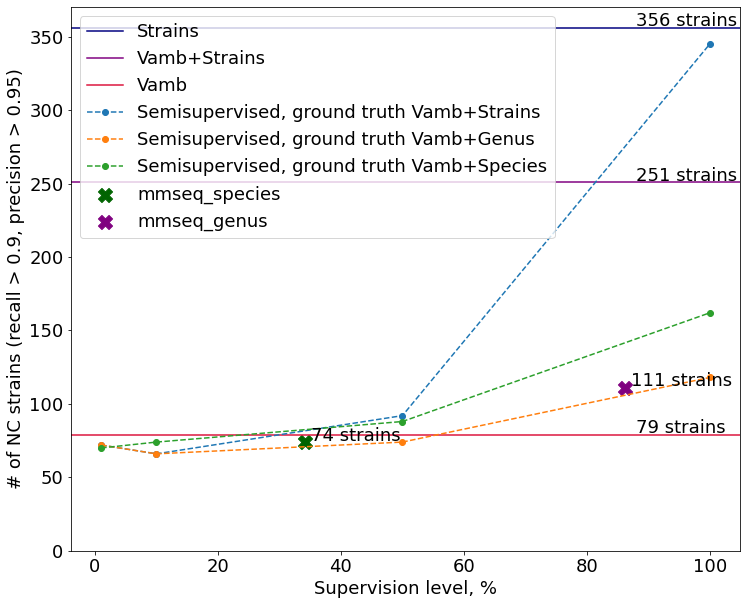

In [455]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(12, 10))
rec, prec = 0.9, 0.95

plt.axhline(y=bins_labels.counters[0][(rec, prec)], color='navy', label='Strains')
plt.text(87 + 1, 356 + 1, f'{bins_labels.counters[0][(rec, prec)]} strains')

plt.axhline(y=bins_concat.counters[0][(rec, prec)], color='purple', label='Vamb+Strains')
plt.text(87 + 1, bins_concat.counters[0][(rec, prec)] + 1, f'{bins_concat.counters[0][(rec, prec)]} strains')

plt.axhline(y=bins_vamb.counters[0][(rec, prec)], color='crimson', label='Vamb')
plt.text(87 + 1, bins_vamb.counters[0][(rec, prec)] + 1, f'{bins_vamb.counters[0][(rec, prec)]} strains')


plt.plot(sup_levels, [b.counters[0][(rec, prec)] for b in bins_fix], 'o--', label='Semisupervised, ground truth Vamb+Strains')
# plt.plot(sup_levels, [b.counters[0][(rec, prec)] for b in bins_vamb_sup], 'o--', label='Semisupervised, input Vamb')
# plt.plot(sup_levels, [b.counters[0][(rec, prec)] for b in bins_labels_sup], 'o--', label='Semisupervised, input Labels')

plt.plot(sup_levels, [b.counters[0][(rec, prec)] for b in bins_genus], 'o--', label='Semisupervised, ground truth Vamb+Genus')
plt.plot(sup_levels, [b.counters[0][(rec, prec)] for b in bins_species], 'o--', label='Semisupervised, ground truth Vamb+Species')



plt.scatter([64054.0*100 / 187685], [b.counters[0][(rec, prec)] for b in bins_mmseq], 
            s=[200], marker='X', label='mmseq_species', color='darkgreen')
a = bins_mmseq[0].counters[0][(rec, prec)]
plt.text(64054.0*100 / 187685 + 1, a + 1, f'{a} strains')

plt.scatter([161719.0*100 / 187685], [b.counters[0][(rec, prec)] for b in bins_mmseq_genus], 
            s=[200], marker='X', label='mmseq_genus', color='purple')
a = bins_mmseq_genus[0].counters[0][(rec, prec)]
plt.text(161719.0*100 / 187685 + 1, a + 1, f'{a} strains')

plt.ylim((0, 370))
# plt.xlim((0, 100))
plt.ylabel(f'# of NC strains (recall > {rec}, precision > {prec})')
plt.xlabel('Supervision level, %')
plt.legend()
plt.savefig('/Users/nmb127/Downloads/mmseq_depths.png')
plt.show()